<a href="https://colab.research.google.com/github/yehuda-yu/ML_Projects/blob/main/CNN_Rock_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Course 70938** - Machine learning in earth and environmental sciences.

**Assignment05 - CNN**

**Name**: Yehuda Yungstein

**ID**: 205487143

**Lecturer**: Efrat Morin (Institute of Earth Sciences, Hebrew University)

# Prelminraries

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data.dataset import Dataset
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision
from torchvision import transforms
from torchvision.io import read_image

Setting global parameters:

In [3]:
# This pathroot assumes the images are in subfolders of the following path, each sub-folder is the class name.
# Make sure your data is in the expected file structure.
PATH_ROOT = "/content/drive/MyDrive/gdrive_folder/Courses/course70938ML/HW/Assingment04/Rocks/" 

IMG_H = 100 # Image height after resize
IMG_W = 100 # Image width after resize
IMG_CH = 3 # Channel number
CLASS_NUM = 7 # Number of classes (number of sub-folders with jpg files in PATH_ROOT)

# Since reading image and label data takes time, after first time you can save
# it as numpy array file and then the data from this file.  
data_numpy_was_saved = True # Set this to True if you already saved the data
path_numpy_arrays = PATH_ROOT+'rocks.npz' # Path of the numpy array file

# Defining and initializing the dataset


`torch.utils.data.Dataset` is an abstract class representing a dataset. It inherits Dataset and must implement three functions: `__init__`, `__len__`, and `__getitem__`.
- The `__init__` function is run once when instantiating the Dataset object. Here we will read the image data and the labels, arrange them in numpy arrays and define other parameters. Note the images are arranged in folders where the folder name is the class name. Also, the images are in different sizes so we use `resize` to be of equal sizes. If the data was already saved to a file of numpy arrays we will read the image and label data from this file. 
- The `__len__` function returns the number of samples in our datasets.
- The `__getitem__` function returns a sample from the dataset at the given index `idx`. Based on the index, it converts the relevant image and label to tensors, calls the transform functions on them (if applicable), and returns the
tensor image and corresponding label in a tuple.


TODO: You should write the `__getitem__` and `__len__` methods. You can base it on Tutoring06, but note how the image and label data are kept in our case (see `__init__`).

In [4]:
class Rocks(Dataset):

  def __init__(self, root_data_path, load_imageandlabels=True, 
               path_numpy_arrays=None, transform=None, target_transform=None):
    path = os.path.join(root_data_path,'*','*.jpg')
    self.classes = []
    text = glob.glob(os.path.join(root_data_path,'*'))
    for t in text:
      cl = t.split('/')[-1]
      self.classes.append(cl)        
    if load_imageandlabels == True:
      data_path = glob.glob(path)
      lst = []
      self.labels = [] 
      for img_path in data_path:
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        img = cv2.resize(img,(IMG_W, IMG_H)) # The images may be in different sizes
        lst.append(img)
        cl = img_path.split('/')[-2]
        la = self.classes.index(cl)
        self.labels.append(la)
      self.data = np.stack(lst, axis=0)
      if path_numpy_arrays is not None:
        np.savez(path_numpy_arrays, self.data, self.labels)
    else:
      if path_numpy_arrays is not None:
        npzfile = np.load(path_numpy_arrays)
        self.data = npzfile['arr_0']
        self.labels= npzfile['arr_1']

    self.transform = transform
    self.target_transform = target_transform

  def __getitem__(self, idx): 
    img = self.data[idx]
    lbl = self.labels[idx]
    if self.transform:
      img = self.transform(img)
    if self.target_transform:
      lbl = self.target_transform(lbl)
    return img, lbl
  
  def __len__(self): 
    return len(self.labels)

Transforms include moving the image into a tensor and normalizing it.

Note that `transforms.ToTensor` Converts a PIL Image or numpy.ndarray (H x W x C) in the range [0, 255] to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0] (the scaling depends on the image type). 

Note that, in principle, the Normalize transform intends to standardize the data by subtracting the mean and dividing by std, per channel. This requires the computation of the mean and std from the training dataset. Here we just use 0.5 for the mean and 0.29 for std, for all channels, which are taken from the moments of the uniform distribution between 0 and 1. These should be good enough for data normalization.

The labels are just transferred from numpy to tensor.

In [5]:
image_transform = transforms.Compose([
      transforms.ToTensor(), 
      transforms.transforms.Normalize((0.5, 0.5, 0.5), (0.29, 0.29, 0.29))
                                      ])
target_transform = transforms.Lambda(lambda y: torch.tensor(y))

Initializing the dataset

In [6]:
if data_numpy_was_saved:
  all_data_dataset = Rocks(PATH_ROOT, load_imageandlabels=False, path_numpy_arrays=path_numpy_arrays,
                           transform=image_transform, target_transform=target_transform)
else:
  all_data_dataset = Rocks(PATH_ROOT, load_imageandlabels=True, path_numpy_arrays=path_numpy_arrays,  
                           transform=image_transform, target_transform=target_transform)
  data_numpy_was_saved = True


# Defining, training and evaluating the model


We want to be able to train our model on a hardware accelerator like the GPU,
if it is available. Let's check to see if
[torch.cuda](https://pytorch.org/docs/stable/notes/cuda.html) is available, else we
continue to use the CPU.



In [7]:
device = (torch.device('cuda') if torch.cuda.is_available()
  else torch.device('cpu'))
print(f"Training on device {device}.")

Training on device cuda.


In [8]:
learning_rate = 0.001
batch_size = 32
epoch_num = 50
weight_decay = 0.1

``DataLoader`` wraps an iterable around a ``Dataset`` to enable easy access to the samples. It allows batching, shuffling and parallelizing.

Note that our dataset includes all data and it is not a-priory divided into train, validation and test, so we will create separate loaders for each group by splitting randomly shuffled data indices.

In [9]:
train_validation_split = 0.70 
validation_test_split = 0.85 
shuffle_dataset = True
random_seed = 10 # Make this None to have a different shuffling each run

# Creating random data indices for training, validation and testing splits:
dataset_size = len(all_data_dataset)
indices = list(range(dataset_size))
split_val = int(np.floor(train_validation_split * dataset_size))
split_test = int(np.floor(validation_test_split * dataset_size))
if shuffle_dataset:
  if random_seed is not None:
    np.random.seed(random_seed)
  np.random.shuffle(indices)
train_indices, val_indices, test_indices = indices[:split_val], indices[split_val:split_test], indices[split_test:]

# Creating data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)
test_sampler = SubsetRandomSampler(test_indices)

train_loader = torch.utils.data.DataLoader(all_data_dataset, batch_size=batch_size,
                                          sampler=train_sampler, pin_memory=True)
validation_loader = torch.utils.data.DataLoader(all_data_dataset, batch_size=batch_size,
                                          sampler=valid_sampler, pin_memory=True)
test_loader = torch.utils.data.DataLoader(all_data_dataset, batch_size=batch_size, 
                                          sampler=test_sampler, pin_memory=True)

In [11]:
def train_loop(dataloader, model, loss_fn, optimizer):
    model.train()

    num_batches = len(dataloader)
    total_loss = 0
    total_correct_pred = 0
    total_instances = 0

    # For each batch
    for X, y in dataloader:
        # Moving to the right device
        X = X.to(device=device)
        y = y.to(device=device)

        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Summing loss and correct predictions
        total_loss += loss.item()
        total_correct_pred += (pred.argmax(1) == y).type(torch.float).sum().item()
        total_instances += len(y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    avg_loss = total_loss / num_batches
    accuracy = total_correct_pred / total_instances

    print('Training average loss = {:.2f}, accuracy = {:.2f}'.format(avg_loss, accuracy))
    return avg_loss, accuracy

def val_loop(dataloader, model, loss_fn):
  model.eval()

  num_batches = len(dataloader)
  total_loss = 0
  total_correct_pred = 0
  total_instances = 0

  with torch.no_grad(): 
    # For each batch
    for X, y in dataloader:
      # Put data on the same device like the model
      X = X.to(device=device)
      y = y.to(device=device)

      # Compute prediction and loss
      pred = model(X)
      loss = loss_fn(pred, y)

      # Summing loss and correct predictions
      total_loss += loss.item()
      total_correct_pred += (pred.argmax(1) == y).type(torch.float).sum().item()
      total_instances += len(y)

  avg_loss = total_loss / num_batches
  accuracy = total_correct_pred / total_instances
  print('Validation average loss = {:.2f}, accuracy = {:.2f}'.format(avg_loss, accuracy))
  return avg_loss, accuracy

def fit(model, loss_fn, optimizer, epochs):
  train_loss_history = []
  val_loss_history = []
  train_accuracy_history = []
  val_accuracy_history = []
  best_param = {}

  for t in range(epochs):
      print(f"\nEpoch {t+1}\n-------------------------------")
      train_loss, train_correct = train_loop(train_loader, model, loss_fn, optimizer)
      val_loss, val_correct = val_loop(validation_loader, model, loss_fn)

      train_loss_history.append(train_loss)
      val_loss_history.append(val_loss)
      train_accuracy_history.append(train_correct)
      val_accuracy_history.append(val_correct)


      if val_loss == np.min(val_loss_history):
        best_param = model.state_dict()
  print("Done!")

  history = [train_loss_history, val_loss_history, train_accuracy_history, val_accuracy_history]
  #model.load_state_dict(best_param)
  return history

# CNN model - 1
This model architecture will be by the instractions of the assignment:

In [12]:
class CNN1(nn.Module):

  def __init__(self):
    super(CNN1, self).__init__()
    # 2 convulution layers, relu activation for each
    self.cnn_layers = nn.Sequential(
            nn.Conv2d(in_channels=IMG_CH, out_channels=64, kernel_size=3, stride=1, padding='same'),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding='same'),
            nn.ReLU())

    # max pooling layer:
    self.pool_layer = nn.MaxPool2d(kernel_size=2, stride=2)
  
    # Flatten layer
    self.flatten_layer = nn.Flatten()

    # 2 fully connected layers
    self.fc_layer = nn.Sequential(
            nn.Linear(50*50*64, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU())
    
    # Output layer
    self.output_layer = nn.Linear(64, CLASS_NUM) 

  def forward(self, x):
    x = self.cnn_layers(x)
    x = self.pool_layer(x)
    x = self.flatten_layer(x)
    x = self.fc_layer(x)
    results_class = self.output_layer(x)
    return results_class

Print the model and its parameters.

Read in Pytorch documentation about parameter initialization.

In [13]:
model = CNN1().to(device)
print(f"Model structure: {model}\n\n")

# for name, param in model.named_parameters():
    # print(f"Layer: {name} | Size: {param.size()} | Values : {param[:2]} \n")

Model structure: CNN1(
  (cnn_layers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (3): ReLU()
  )
  (pool_layer): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten_layer): Flatten(start_dim=1, end_dim=-1)
  (fc_layer): Sequential(
    (0): Linear(in_features=160000, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
  )
  (output_layer): Linear(in_features=64, out_features=7, bias=True)
)




In [14]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,weight_decay=weight_decay)
train_loss_history,train_accuracy_history = [],[]
val_loss_history,val_accuracy_history = [],[]
for t in range(epoch_num):
  print(f"Epoch {t+1}\n-------------------------------")
  train_loss , train_accuracy = train_loop(train_loader, model, loss_fn, optimizer)
  val_loss,val_accuracy = val_loop(validation_loader, model, loss_fn)
  train_loss_history.append(train_loss)
  train_accuracy_history.append(train_accuracy)
  val_loss_history.append(val_loss)
  val_accuracy_history.append(val_accuracy)
  print("\n-------------------------------")
print("Done!")

Epoch 1
-------------------------------
Training average loss = 1.65, accuracy = 0.38
Validation average loss = 1.46, accuracy = 0.46

-------------------------------
Epoch 2
-------------------------------
Training average loss = 1.47, accuracy = 0.42
Validation average loss = 1.42, accuracy = 0.48

-------------------------------
Epoch 3
-------------------------------
Training average loss = 1.45, accuracy = 0.45
Validation average loss = 1.40, accuracy = 0.44

-------------------------------
Epoch 4
-------------------------------
Training average loss = 1.44, accuracy = 0.42
Validation average loss = 1.38, accuracy = 0.49

-------------------------------
Epoch 5
-------------------------------
Training average loss = 1.43, accuracy = 0.44
Validation average loss = 1.42, accuracy = 0.46

-------------------------------
Epoch 6
-------------------------------
Training average loss = 1.44, accuracy = 0.44
Validation average loss = 1.41, accuracy = 0.41

------------------------------

Plot learning curves based on loss and accuracy (saved in the previous code cell)

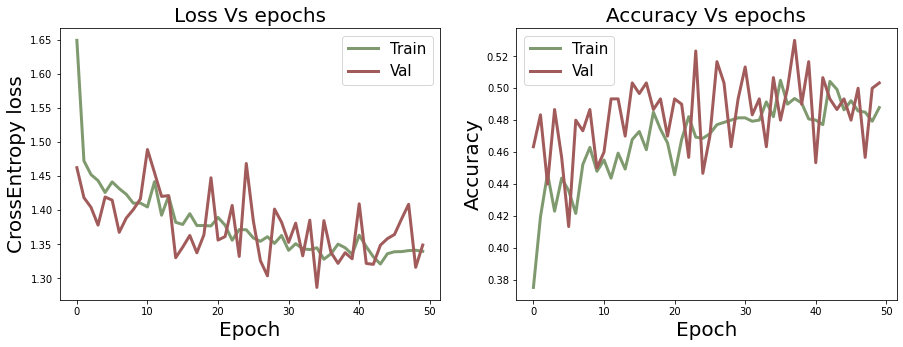

In [15]:
plt.figure(figsize=(15, 5))

plt.subplot(1,2,1)
plt.plot(train_loss_history,color = '#809A6F',lw=3, label='Train')
plt.plot(val_loss_history,color = '#A25B5B',lw=3, label='Val')
plt.xlabel('Epoch',fontsize=20)
plt.ylabel('CrossEntropy loss',fontsize=20)
plt.title('Loss Vs epochs',fontsize=20)
plt.legend(fontsize=15)

plt.subplot(1,2,2)
plt.plot(train_accuracy_history,color = '#809A6F',lw=3, label='Train')
plt.plot(val_accuracy_history,color = '#A25B5B',lw=3, label='Val')
plt.xlabel('Epoch',fontsize=20)
plt.ylabel('Accuracy',fontsize=20)
plt.title('Accuracy Vs epochs',fontsize=20)
plt.legend(fontsize=15)

plt.show()

# Model 2 - AlexNet
Now i will try to improve the model cy changing the model's hyperparameters and architecture:

1. **Learning rate** = 0.0005
2. **Epochs** = 50
3. **Batch size** = 32 

Now lets change the model architecture to find the bess model (combination of minimum loss + maximum accuracy whithout overfit). I will use the Alexnet architecture as attached in the image:

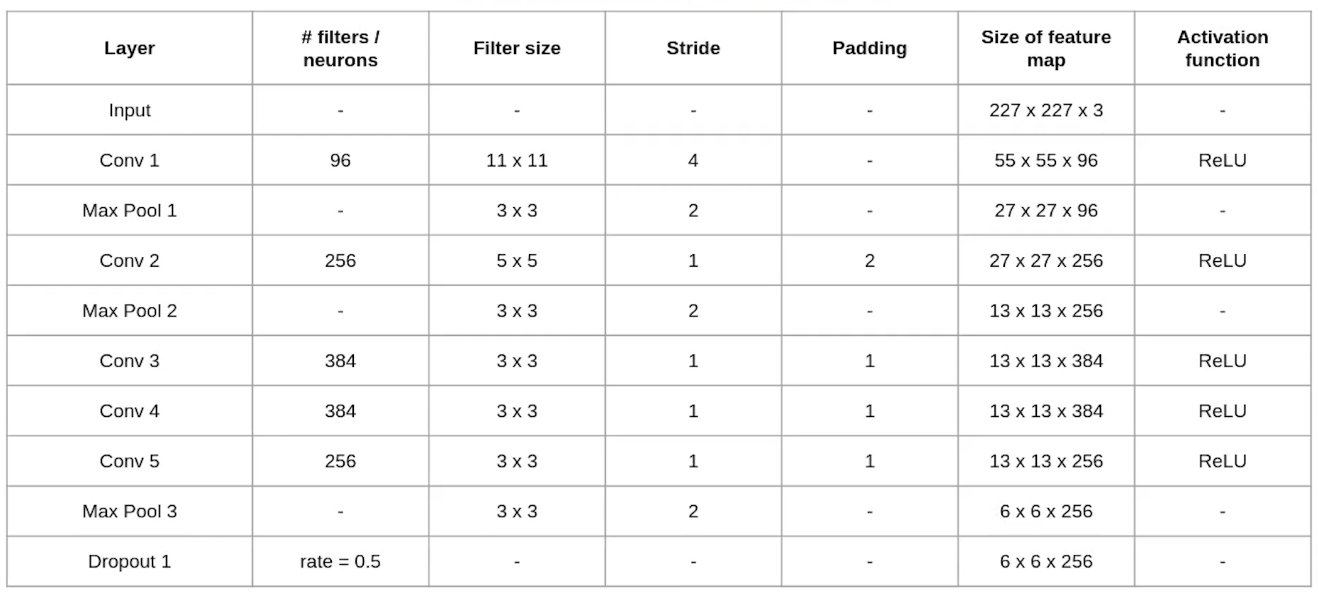

In [44]:
# Hyper-parameters
learning_rate = 0.0005
batch_size = 32
epoch_num = 50
weight_decay = 0


# Model Defenition
class CNN2(nn.Module):

  def __init__(self):
    super(CNN2, self).__init__()
    self.cnn_layers = nn.Sequential(
            nn.Conv2d(IMG_CH,64, 11, 1, 'same'),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(64, 256, 5, 1,2),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(3, 2),
            nn.Conv2d(256, 384, 3, 1,1),
            nn.BatchNorm2d(384),
            nn.ReLU(),            
            nn.Conv2d(384, 384, 3, 1,1),
            nn.BatchNorm2d(384),
            nn.ReLU(),  
            nn.Conv2d(384, 256, 3, 1,1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(3, 2),
            nn.Dropout(0.5))                                    
  
    # Flatten layer
    self.flatten_layer = nn.Flatten()

    # 2 fully connected layers
    self.fc_layer = nn.Sequential(
            nn.Linear(30976, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(32, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(0.5))
    
    # Output layer
    self.output_layer = nn.Linear(32, CLASS_NUM) 

  def forward(self, x):
    x = self.cnn_layers(x)
    x = self.flatten_layer(x)
    x = self.fc_layer(x)
    results_class = self.output_layer(x)
    return results_class

# Creat & Describe model structure
model2 = CNN2().to(device)
print(f"Model structure: {model2}\n\n")


# Run train & validation loops
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model2.parameters(), lr=learning_rate,weight_decay=weight_decay)
train_loss_history,train_accuracy_history = [],[]
val_loss_history,val_accuracy_history = [],[]
for t in range(epoch_num):
  print(f"Epoch {t+1}\n-------------------------------")
  train_loss , train_accuracy = train_loop(train_loader, model2, loss_fn, optimizer)
  val_loss,val_accuracy = val_loop(validation_loader, model2, loss_fn)
  train_loss_history.append(train_loss)
  train_accuracy_history.append(train_accuracy)
  val_loss_history.append(val_loss)
  val_accuracy_history.append(val_accuracy)
  print("\n-------------------------------")
print("Done!")

Model structure: CNN2(
  (cnn_layers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(1, 1), padding=same)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU()
    (14): Conv2d(384, 256, kernel_size=(3, 3), str

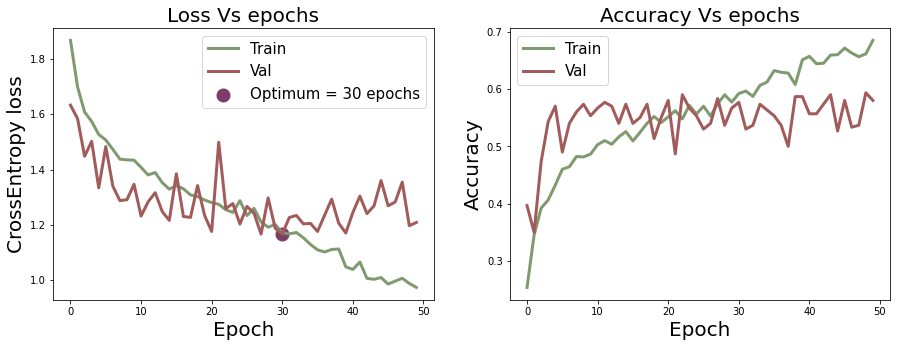

In [46]:
plt.figure(figsize=(15, 5))

plt.subplot(1,2,1)
plt.plot(train_loss_history,color = '#809A6F',lw=3, label='Train')
plt.plot(val_loss_history,color = '#A25B5B',lw=3, label='Val')
plt.scatter(30,np.array(val_loss_history).min(),color = "#7C3E66",lw=8,label = "Optimum = 30 epochs")
plt.xlabel('Epoch',fontsize=20)
plt.ylabel('CrossEntropy loss',fontsize=20)
plt.title('Loss Vs epochs',fontsize=20)
plt.legend(fontsize=15)

plt.subplot(1,2,2)
plt.plot(train_accuracy_history,color = '#809A6F',lw=3, label='Train')
plt.plot(val_accuracy_history,color = '#A25B5B',lw=3, label='Val')
plt.xlabel('Epoch',fontsize=20)
plt.ylabel('Accuracy',fontsize=20)
plt.title('Accuracy Vs epochs',fontsize=20)
plt.legend(fontsize=15)

plt.show()

# Model 3

In [23]:
# Hyper-parameters
learning_rate = 0.0005
batch_size = 32
epoch_num = 50
weight_decay = 0


# Model Defenition
class CNN3(nn.Module):

  def __init__(self):
    super(CNN3, self).__init__()
    self.cnn_layers = nn.Sequential(
                      nn.Conv2d(IMG_CH, 64, 7, 1, 'same'), # 64 x 100 x 100
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # 64 x 50 x 50

            nn.Conv2d(64, 128, 3, 1, 'same'), # 128 x 50 x 50
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, 3, 1, 'same'), # 128 x 50 x 50
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # 128 x 25 x 25

            nn.Conv2d(128, 256, 3, 1, 'same'), # 256 x 25 x 25
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, 1, 'same'), # 256 x 25 x 25
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # 256 x 12 x 12 (rounded down)
            )                                    
  
    # Flatten layer
    self.flatten_layer = nn.Flatten()

    # 2 fully connected layers
    self.fc_layer = nn.Sequential(
            nn.Linear(256 * 12 * 12, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.5))
    
    # Output layer
    self.output_layer = nn.Linear(64, CLASS_NUM) 

  def forward(self, x):
    x = self.cnn_layers(x)
    x = self.flatten_layer(x)
    x = self.fc_layer(x)
    results_class = self.output_layer(x)
    return results_class

# Creat & Describe model structure
model3 = CNN3().to(device)
print(f"Model structure: {model3}\n\n")


# Run train & validation loops
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model3.parameters(), lr=learning_rate,weight_decay=weight_decay)
train_loss_history,train_accuracy_history = [],[]
val_loss_history,val_accuracy_history = [],[]
for t in range(epoch_num):
  print(f"Epoch {t+1}\n-------------------------------")
  train_loss , train_accuracy = train_loop(train_loader, model3, loss_fn, optimizer)
  val_loss,val_accuracy = val_loop(validation_loader, model3, loss_fn)
  train_loss_history.append(train_loss)
  train_accuracy_history.append(train_accuracy)
  val_loss_history.append(val_loss)
  val_accuracy_history.append(val_accuracy)
  print("\n-------------------------------")
print("Done!")

Model structure: CNN3(
  (cnn_layers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=same)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU()
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 

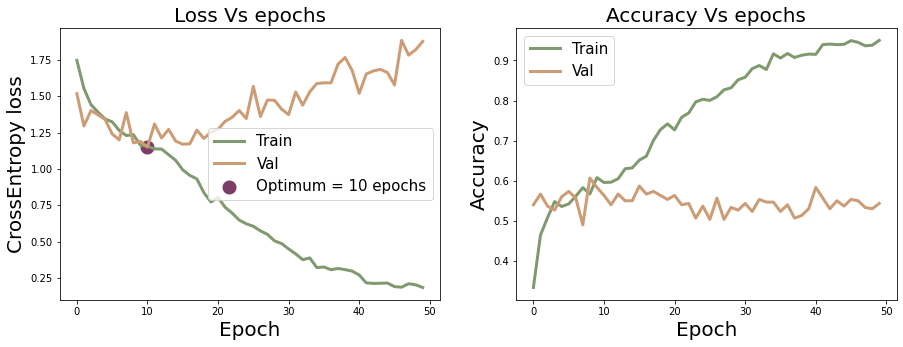

In [38]:
plt.figure(figsize=(15, 5))

plt.subplot(1,2,1)

plt.plot(train_loss_history,color = '#809A6F',lw=3, label='Train')
plt.plot(val_loss_history,color = '#CC9C75',lw=3, label='Val')
plt.scatter(10,np.array(val_loss_history).min(),color = "#7C3E66",lw=8,label = "Optimum = 10 epochs")
plt.xlabel('Epoch',fontsize=20)
plt.ylabel('CrossEntropy loss',fontsize=20)
plt.title('Loss Vs epochs',fontsize=20)

plt.legend(fontsize=15)

plt.subplot(1,2,2)
plt.plot(train_accuracy_history,color = '#809A6F',lw=3, label='Train')
plt.plot(val_accuracy_history,color = '#CC9C75',lw=3, label='Val')
plt.xlabel('Epoch',fontsize=20)
plt.ylabel('Accuracy',fontsize=20)
plt.title('Accuracy Vs epochs',fontsize=20)
plt.legend(fontsize=15)

In [27]:
np.array(val_loss_history).min()

1.1504070699214934

# Evaluate final model with the test dataset

After you are satisfied with the final model, compute accuracy (and potentially other performance metrics) using the test dataset.

**lets evaluate the est dataset with Model 2**

In [50]:
def test_loop(dataloader, model):
  epoch_accuracy = 0
  total = 0

  model.eval()
  with torch.no_grad(): 
    for X, y in dataloader:
      # Put data on the same device like the model
      X = X.to(device=device)
      y = y.to(device=device)
      pred = model(X)

      # Update for average loss and accuracy
      total += len(y)
      epoch_accuracy += (pred.argmax(1) == y).type(torch.float).sum().item()

  epoch_accuracy /= total

  return epoch_accuracy

test_accuracy = test_loop(test_loader, model2)
print(f'Test accuracy model 2 : {test_accuracy:.3f}')

Test accuracy model 2 : 0.551


Present a sample of images, their predicted vs. real class and accuracy for the sample. 

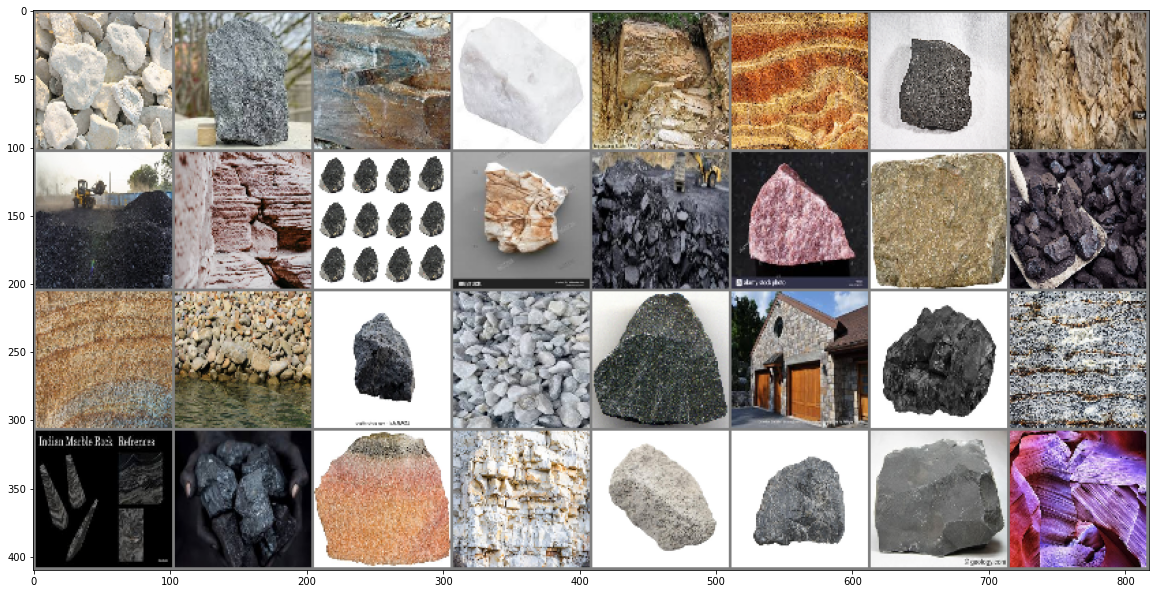

Accuracy for the batch:  0.47

    Label-Predicted
    ---------------
 1: Coal-Coal 
 2: Basalt-Quartzite 
 3: Quartzite-Quartzite 
 4: Basalt-Basalt 
 5: Quartzite-Quartzite 
 6: Granite-Granite 
 7: Marble-Sandstone 
 8: Basalt-Coal 
 9: Sandstone-Quartzite 
10: Granite-Coal 
11: Marble-Sandstone 
12: Basalt-Basalt 
13: Sandstone-Sandstone 
14: Quartzite-Quartzite 
15: Coal-Quartzite 
16: Sandstone-Sandstone 
17: Granite-Quartzite 
18: Coal-Coal 
19: Marble-Sandstone 
20: Basalt-Coal 
21: Marble-Quartzite 
22: Quartzite-Granite 
23: Sandstone-Sandstone 
24: Limestone-Coal 
25: Basalt-Sandstone 
26: Sandstone-Sandstone 
27: Basalt-Quartzite 
28: Coal-Coal 
29: Coal-Coal 
30: Coal-Sandstone 
31: Coal-Quartzite 
32: Granite-Granite 



In [51]:
def imshow(img):
  img = img * 0.29 + 0.5 # Unnormalize
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()

classes = all_data_dataset.classes

# Get a batch of test images and labels and show images
X, y = iter(test_loader).next()
plt.figure(figsize=(20, 15))
imshow(torchvision.utils.make_grid(X))

# Compute and present the label's class vs. the predicted class and the batch's accuracy.
model2.eval()
with torch.no_grad():
  X = X.to(device=device)
  y = y.to(device=device)
  pred = model2(X)
  predicted = pred.argmax(1)
  test_accuracy = (predicted == y).type(torch.float).sum().item() / len(y)
print(f'Accuracy for the batch: {test_accuracy : .2f}\n')
print('    Label-Predicted')
print('    ---------------')
print(''.join(f'{j+1:2d}: {classes[y[j]]:4s}-{classes[predicted[j]]:4s} \n' for j in range(batch_size)))


Confiusion Matrix:

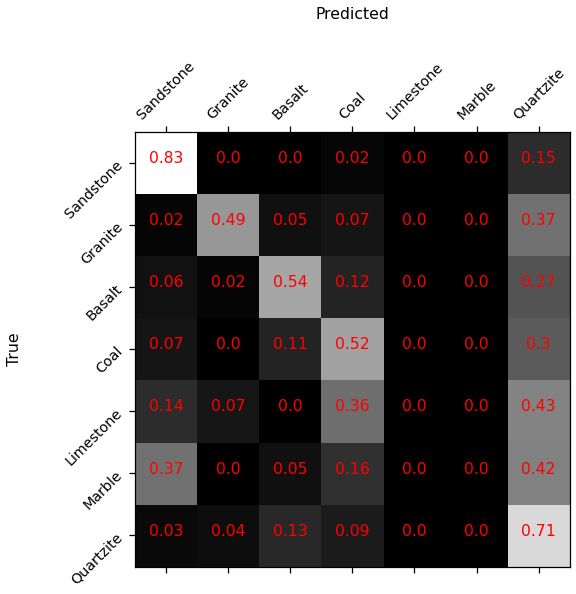

In [52]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
sns.set_context("notebook", font_scale=1.3)

# Creating the test data set in one tensor
true_y = []
model_y = []
model2.eval()
with torch.no_grad(): 
  for X, y in test_loader:
    X = X.to(device=device)
    true_y.append(y.to(device=device))
    model_y.append(model2(X).argmax(1))
true_y = torch.cat(true_y)
model_y = torch.cat(model_y)

# Creating normalized confusion matrix
conf_mx = confusion_matrix(true_y.cpu(), model_y.cpu()) #confusion matrix
row_sums = conf_mx.sum(axis=1, keepdims=True) 
norm_conf_mx = conf_mx / row_sums #normalized every value by the raw

# Plotting
fig, axis = plt.subplots(figsize=(8, 8))
axis.matshow(norm_conf_mx, cmap=plt.cm.gray)
axis.set_xlabel('Predicted', labelpad=40)
axis.xaxis.set_label_position('top')
axis.set_ylabel('True', labelpad=40)
axis.set_xticks(range(len(classes[:-1])))
axis.set_xticklabels(classes[:-1], rotation = 45)
axis.set_yticks(range(len(classes[:-1])))
axis.set_yticklabels(classes[:-1], rotation = 45)
for col in range(len(norm_conf_mx)):
  for row in range(len(norm_conf_mx)):
    axis.text(col, row, round(norm_conf_mx[row,col], 2), color='red', ha='center')